In [ ]:
pip install Riskfolio-lib

In [ ]:
pip install yfinance

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import riskfolio.Portfolio as pf
import riskfolio.PlotFunctions as plf
from numpy import array
from keras.models import Sequential
from keras.layers import SimpleRNN
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from numpy import vstack
from sklearn.ensemble import RandomForestRegressor

MODELLO DI SELEZIONE DI MARKOWITZ

In [ ]:
yf.pdr_override()
pd.options.display.float_format = '{:.4%}'.format
#Range di analisi
start = '2016-01-01'
end = '2019-01-01' 
# Tickers
assets = ['JCI', 'TGT', 'CMCSA', 'CPB', 'MO', 'NBL', 'APA', 'MMC', 'JPM',
          'ZION', 'PSA', 'BAX', 'BMY', 'LUV', 'PCAR', 'TXT', 'DHR',
          'DE', 'MSFT', 'HPQ', 'SEE', 'VZ', 'CNP', 'NI', 'AAPL','AMZN','NFLX','NVDA']
assets.sort()
#Scarico i dati
data = yf.download(assets, start = start, end = end)
data = data.loc[:,('Adj Close', slice(None))]
data.columns = assets
#Rendimenti
Y = data[assets].pct_change().dropna()
Y.head()

[*********************100%***********************]  28 of 28 completed


,AAPL,AMZN,APA,BAX,BMY,CMCSA,CNP,CPB,DE,DHR,FB,HPQ,JCI,JPM,LUV,MMC,MO,MSFT,NBL,NFLX,NI,PCAR,PSA,SEE,TGT,TXT,VZ,ZION
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-05,-2.5059%,-0.5024%,-2.0257%,0.4035%,1.9693%,0.0180%,0.9305%,0.3678%,0.5783%,0.1854%,0.4989%,0.9483%,-1.1953%,0.1729%,1.1916%,0.8284%,2.0213%,0.4562%,0.4478%,-2.0917%,1.5881%,0.0212%,2.8236%,0.9758%,1.7539%,0.2410%,1.3735%,-1.0857%
2016-01-06,-1.9570%,-0.1799%,-11.4863%,0.2412%,-1.7556%,-0.7727%,-1.2473%,-0.1736%,-1.1239%,-1.1649%,0.2336%,-3.5867%,-0.9551%,-1.4436%,0.9185%,-1.2051%,1.0589%,-1.8165%,-5.8247%,9.3071%,0.5547%,0.0212%,0.1592%,-1.5646%,-1.0155%,-3.0048%,-0.9034%,-2.9145%
2016-01-07,-4.2205%,-3.9058%,-5.1389%,-1.6573%,-2.7699%,-1.1047%,-1.9769%,-1.2207%,-0.8855%,-2.5666%,-4.9043%,-4.6059%,-2.5394%,-4.0439%,-2.1004%,-0.7577%,-1.7407%,-3.4783%,-2.5245%,-2.6513%,-2.2066%,-3.0309%,-1.0410%,-3.1557%,-0.2700%,-2.0570%,-0.5492%,-3.0019%
2016-01-08,0.5288%,-0.1464%,0.2737%,-1.6037%,-2.5425%,0.1099%,-0.2241%,0.5707%,-1.6402%,0.0565%,-0.6025%,-1.7642%,-0.1649%,-2.2399%,0.6198%,-1.3966%,0.1720%,0.3067%,-0.1942%,-2.7671%,-0.1538%,-1.1366%,-0.7308%,-0.1448%,-3.3839%,-1.1387%,-0.9719%,-1.1254%
2016-01-11,1.6192%,1.7610%,-4.3384%,-1.6851%,-1.0215%,0.0914%,-1.1791%,0.5674%,0.5287%,-0.0565%,0.1849%,0.6616%,0.0330%,-0.1527%,-0.4028%,-1.4542%,2.0948%,-0.0573%,-5.9682%,3.2139%,1.6435%,0.0000%,0.9869%,-0.1450%,1.4570%,-0.4607%,0.5800%,-1.9918%


In [ ]:
#Ottimizzazione di portafoglio approccio storico
port = pf.Portfolio(returns=Y)
method_mu='hist' # Method to estimate expected returns based on historical data.
method_cov='hist' # Method to estimate covariance matrix based on historical data.
port.assets_stats(method_mu=method_mu, method_cov=method_cov, d=0.94)
#Stima del portafoglio ottiamale
model='Classic' #Markowitz
rm = 'MV' #media-Varianza
obj = 'Sharpe' #ottimizzazione indice di Sharpe
hist = True #scenari storici come misura di rischio
rf = 0 # Risk free rate
l = 0 #Fattore avversità rispetto al rischio
#Pesi del portafoglio ottimale
w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)
print(w.T)

           AAPL     AMZN     APA     BAX  ...     TGT     TXT      VZ    ZION
weights 0.0000% 10.1156% 0.0000% 9.4460%  ... 0.0000% 0.0000% 6.6935% 0.0093%

[1 rows x 28 columns]


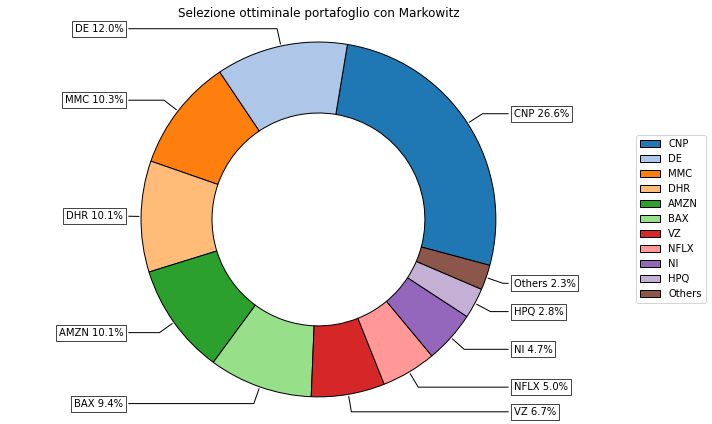

In [ ]:
# Plotting 
ax = plf.plot_pie(w=w, title='Selezione ottiminale portafoglio con Markowitz', others=0.05, nrow=25, cmap = "tab20",height=6, width=10, ax=None)


In [ ]:
#Frontiera Efficiente
points = 100 #Numero di punti simulati
frontier1 = port.efficient_frontier(model=model, rm=rm, points=points, rf=rf, hist=hist)
print(frontier1.T.head())

     AAPL    AMZN     APA     BAX  ...     TGT     TXT       VZ    ZION
0 3.2778% 0.0000% 0.0000% 5.3761%  ... 4.9650% 0.5866%  9.8676% 0.4423%
1 3.6194% 2.2304% 0.0000% 7.7424%  ... 3.6848% 0.0000% 12.1545% 0.2515%
2 3.1842% 3.2781% 0.0000% 8.4052%  ... 2.7970% 0.0000% 13.2547% 0.1164%
3 2.6366% 4.2114% 0.0000% 8.8632%  ... 1.9423% 0.0000% 13.8929% 0.0000%
4 1.1879% 5.6927% 0.0000% 9.3204%  ... 0.0972% 0.0000% 13.1476% 0.0000%

[5 rows x 28 columns]


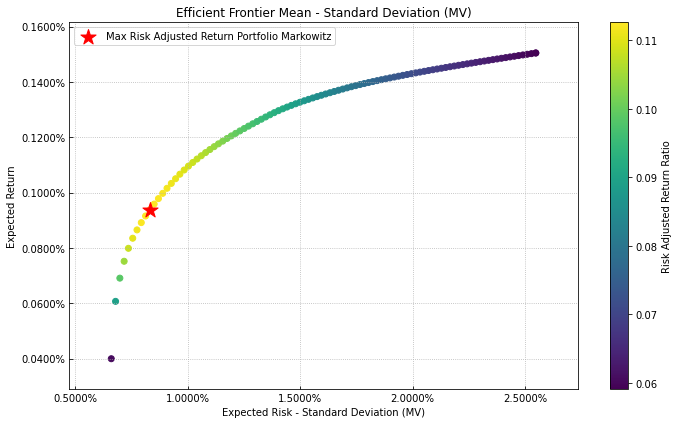

In [ ]:
# Plotting the efficient frontier
label = 'Max Risk Adjusted Return Portfolio Markowitz' # Title of point
mu = port.mu # Expected returns
cov = port.cov # Covariance matrix
returns = port.returns # Returns of the assets
ax = plf.plot_frontier(w_frontier=frontier1, mu=mu, cov=cov, returns=returns, rm=rm,
                       rf=rf, alpha=0.01, cmap='viridis', w=w, label=label,
                       marker='*', s=16, c='r', height=6, width=10, ax=None)


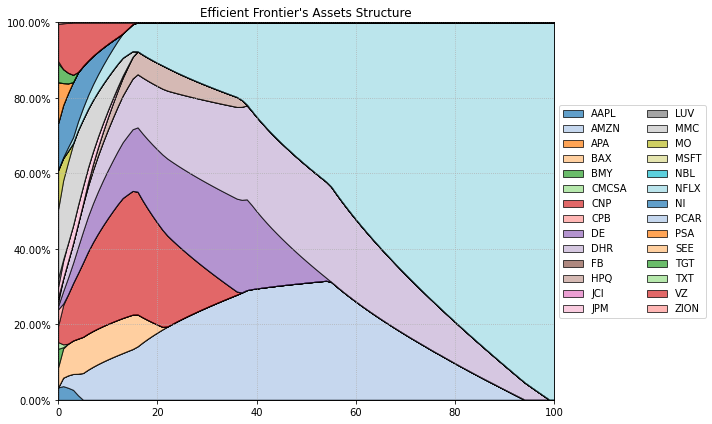

In [ ]:
# Plotting efficient frontier composition
ax = plf.plot_frontier_area(w_frontier=frontier1, cmap="tab20", height=6, width=10, ax=None)


MODELLO DI SELEZIONE CON RECURRENT NEURAL NETWORK

In [ ]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)


In [ ]:
#Range di analisi
startRF = '2010-01-01'
endRF = '2019-01-01'
#Tickers 
assets = ['JCI', 'TGT', 'CMCSA', 'CPB', 'MO', 'NBL', 'APA', 'MMC', 'JPM',
          'ZION', 'PSA', 'BAX', 'BMY', 'LUV', 'PCAR', 'TXT', 'DHR',
          'DE', 'MSFT', 'HPQ', 'SEE', 'VZ', 'CNP', 'NI', 'AAPL','AMZN','NFLX','NVDA']
assets.sort()
#Scarico i dati
dataRF = yf.download(assets, start = startRF, end = endRF)
dataRF = dataRF.loc[:,('Adj Close', slice(None))]
dataRF.columns = assets
#Rendimenti
YRF = dataRF[assets].pct_change().dropna()
YRF.head()

[*********************100%***********************]  28 of 28 completed


,AAPL,AMZN,APA,BAX,BMY,CMCSA,CNP,CPB,DE,DHR,FB,HPQ,JCI,JPM,LUV,MMC,MO,MSFT,NBL,NFLX,NI,PCAR,PSA,SEE,TGT,TXT,VZ,ZION
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2012-05-21,5.8260%,1.9920%,2.7322%,1.2036%,-0.0306%,1.5205%,1.2232%,-1.9461%,2.8966%,2.1524%,-10.9861%,2.0037%,2.7533%,-2.9263%,2.3313%,0.8852%,0.5366%,1.6399%,3.5553%,2.5443%,1.5555%,2.4474%,2.0458%,1.0605%,0.6671%,5.1454%,-0.4575%,1.7515%
2012-05-22,-0.7679%,-1.2746%,-0.1088%,-0.3261%,0.3669%,0.8011%,0.6042%,-0.2443%,-0.5046%,-1.0820%,-8.9039%,-0.5025%,0.6513%,4.6139%,-0.8394%,0.7208%,-0.2826%,0.0336%,-0.3067%,-5.6175%,-0.1612%,0.3116%,-0.7509%,-0.8025%,1.5045%,-0.2127%,0.1209%,0.9688%
2012-05-23,2.4399%,0.9056%,0.3146%,-0.0577%,-0.9442%,-0.5183%,-0.5506%,-0.7652%,1.3613%,1.2282%,3.2258%,-3.2140%,0.8135%,0.7351%,1.0883%,0.4356%,-0.1260%,-2.1841%,0.2485%,6.2029%,-0.1211%,0.6989%,-0.0529%,1.1823%,0.1941%,1.1940%,-0.2657%,1.9190%
2012-05-24,-0.9184%,-0.9389%,-0.9651%,0.6162%,1.4453%,0.4863%,0.8053%,0.4318%,-0.3687%,0.1517%,3.2187%,3.2733%,0.7886%,-0.8464%,4.5454%,0.5886%,1.7024%,-0.1374%,-0.4250%,-2.2806%,0.8893%,-1.0283%,0.6056%,-1.1070%,0.8278%,0.2107%,0.2664%,-1.6736%
2012-05-25,-0.5360%,-1.0918%,0.3533%,-0.4976%,0.3031%,-0.2765%,0.7488%,0.0614%,-0.7004%,-0.1325%,-3.3909%,2.5723%,-0.6550%,-1.3836%,0.2288%,-0.5236%,-0.4650%,-0.0344%,-0.4860%,-0.0712%,0.3205%,-0.3896%,0.2859%,-0.4975%,0.6463%,-1.0933%,0.1450%,0.3723%


In [ ]:
#Split Rendimenti
YnumpyRNN = YRF.to_numpy()
n_steps_out = 10
n_steps_in = YRF.shape[0] - 10
X1, y1 = split_sequences(YnumpyRNN, n_steps_in, n_steps_out)
n_features = len(assets)

In [ ]:
#### define model LSTM
model = Sequential()
model.add(SimpleRNN(100, activation='relu', input_shape=(n_steps_in, n_features)))
model.add(RepeatVector(n_steps_out))
model.add(SimpleRNN(100, activation='relu', return_sequences=True))
model.add(SimpleRNN(100, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(n_features)))
model.compile(optimizer='adam', loss='mse')
### fit model
earlystop = EarlyStopping(monitor='loss', min_delta=0.00001, patience=80,  verbose=2, mode='min')
callbacks_list = [earlystop]
### define model
model.fit(X1, y1, epochs=130, verbose=2, callbacks = callbacks_list, batch_size = 20, shuffle = False)


Epoch 1/130
1/1 - 0s - loss: 8.1405e-04
Epoch 2/130
1/1 - 0s - loss: 6.9235e-04
Epoch 3/130
1/1 - 0s - loss: 6.8220e-04
Epoch 4/130
1/1 - 0s - loss: 6.7165e-04
Epoch 5/130
1/1 - 0s - loss: 6.6320e-04
Epoch 6/130
1/1 - 0s - loss: 6.5598e-04
Epoch 7/130
1/1 - 0s - loss: 6.5229e-04
Epoch 8/130
1/1 - 0s - loss: 6.4742e-04
Epoch 9/130
1/1 - 0s - loss: 6.4164e-04
Epoch 10/130
1/1 - 0s - loss: 6.3739e-04
Epoch 11/130
1/1 - 0s - loss: 6.3423e-04
Epoch 12/130
1/1 - 0s - loss: 6.2888e-04
Epoch 13/130
1/1 - 0s - loss: 6.2434e-04
Epoch 14/130
1/1 - 0s - loss: 6.1979e-04
Epoch 15/130
1/1 - 0s - loss: 6.1426e-04
Epoch 16/130
1/1 - 0s - loss: 6.0786e-04
Epoch 17/130
1/1 - 0s - loss: 6.0000e-04
Epoch 18/130
1/1 - 0s - loss: 5.9338e-04
Epoch 19/130
1/1 - 0s - loss: 5.8528e-04
Epoch 20/130
1/1 - 0s - loss: 5.7456e-04
Epoch 21/130
1/1 - 0s - loss: 5.6603e-04
Epoch 22/130
1/1 - 0s - loss: 5.5710e-04
Epoch 23/130
1/1 - 0s - loss: 5.4838e-04
Epoch 24/130
1/1 - 0s - loss: 5.3603e-04
Epoch 25/130
1/1 - 0s - l

In [ ]:
#prediction
fin = YnumpyRNN.shape[0]
x_input1 = YnumpyRNN[n_steps_out:fin]
x_input1 = x_input1.reshape((1, x_input1.shape[0], n_features))
yhatRNN = model.predict(x_input1, verbose=2)
yhatRNN = yhatRNN.reshape(yhatRNN.shape[1], n_features)
YfinRNN = vstack((YnumpyRNN,yhatRNN))

In [ ]:
#Modello di Markowitz con previsione RNN
YfinRNN = pd.DataFrame(YfinRNN)
YfinRNN.columns = assets
print(YfinRNN.head())
portRNN = pf.Portfolio(returns=YfinRNN)

      AAPL     AMZN      APA      BAX  ...     TGT      TXT       VZ     ZION
0  5.8260%  1.9920%  2.7322%  1.2036%  ... 0.6671%  5.1454% -0.4575%  1.7515%
1 -0.7679% -1.2746% -0.1088% -0.3261%  ... 1.5045% -0.2127%  0.1209%  0.9688%
2  2.4399%  0.9056%  0.3146% -0.0577%  ... 0.1941%  1.1940% -0.2657%  1.9190%
3 -0.9184% -0.9389% -0.9651%  0.6162%  ... 0.8278%  0.2107%  0.2664% -1.6736%
4 -0.5360% -1.0918%  0.3533% -0.4976%  ... 0.6463% -1.0933%  0.1450%  0.3723%

[5 rows x 28 columns]


In [ ]:
#Ottimizzazione di portafoglio approccio storico
method_mu='hist' # Method to estimate expected returns based on historical data.
method_cov='hist' # Method to estimate covariance matrix based on historical data.
portRNN.assets_stats(method_mu=method_mu, method_cov=method_cov, d=0.94)


In [ ]:
#Stima del portafoglio ottimale
model='Classic' #Markowitz
rm = 'MV' #media-Varianza
obj = 'Sharpe' #ottimizzazione indice di Sharpe
hist = True #scenari storici come misura di rischio
rf = 0 # Risk free rate
l = 0 #Fattore avversità rispetto al rischio
#Pesi del portafoglio ottimale
wRNN = portRNN.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)
print(wRNN.T)


           AAPL    AMZN     APA     BAX  ...     TGT     TXT      VZ    ZION
weights 0.0000% 0.0000% 0.0000% 0.0000%  ... 0.0000% 0.0000% 0.0000% 0.0000%

[1 rows x 28 columns]


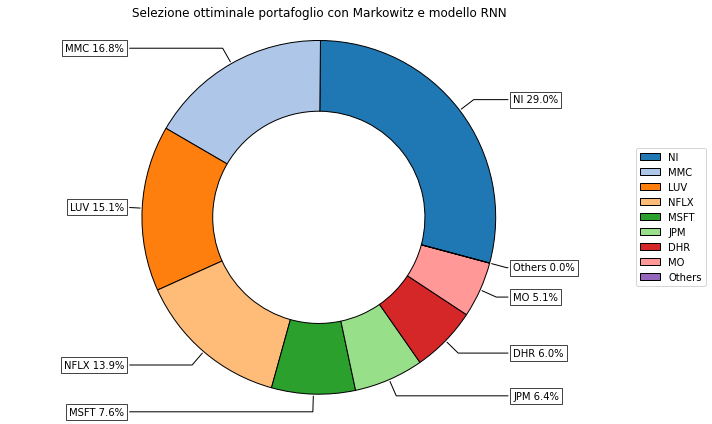

In [ ]:
# Plotting 
axRNN = plf.plot_pie(w=wRNN, title='Selezione ottiminale portafoglio con Markowitz e modello RNN', others=0.05, nrow=25, cmap = "tab20",height=6, width=10, ax=None)


In [ ]:
#Frontiera Efficiente
points = 100 #Numero di punti simulati
frontierRNN = portRNN.efficient_frontier(model=model, rm=rm, points=points, rf=rf, hist=hist)
print(frontierRNN.T.head())

     AAPL    AMZN     APA      BAX  ...     TGT     TXT       VZ    ZION
0 3.0944% 0.0000% 0.0000% 10.5264%  ... 7.1984% 0.0000% 12.3640% 0.3020%
1 0.7638% 0.0000% 0.0000%  9.9894%  ... 4.0406% 0.0000%  6.8319% 0.0000%
2 0.0000% 0.0000% 0.0000%  9.2448%  ... 2.3543% 0.0000%  3.7780% 0.0000%
3 0.0000% 0.0000% 0.0000%  8.3013%  ... 0.9283% 0.0000%  1.1474% 0.0000%
4 0.0000% 0.0000% 0.0000%  7.2301%  ... 0.0000% 0.0000%  0.0000% 0.0000%

[5 rows x 28 columns]


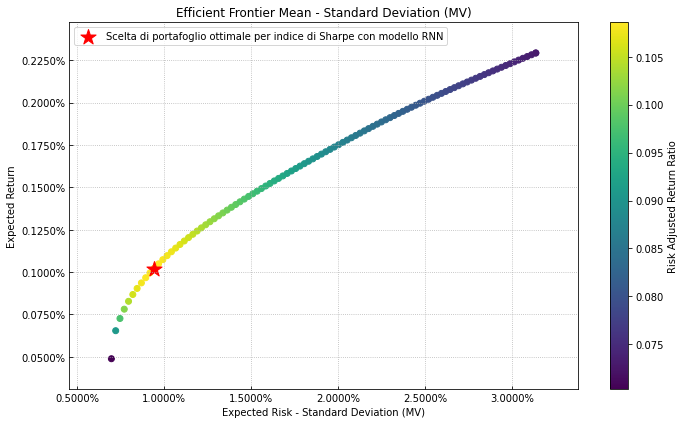

In [ ]:
# Plotting the efficient frontier
labelRNN = 'Scelta di portafoglio ottimale per indice di Sharpe con modello RNN' # Title of point
muRNN = portRNN.mu # Expected returns
covRNN = portRNN.cov # Covariance matrix
returnsRNN = portRNN.returns # Returns of the assets
ax = plf.plot_frontier(w_frontier=frontierRNN, mu=muRNN, cov=covRNN, returns=returnsRNN, rm=rm,
                       rf=rf, alpha=0.01, cmap='viridis', w=wRNN, label=labelRNN,
                       marker='*', s=16, c='r', height=6, width=10, ax=None)


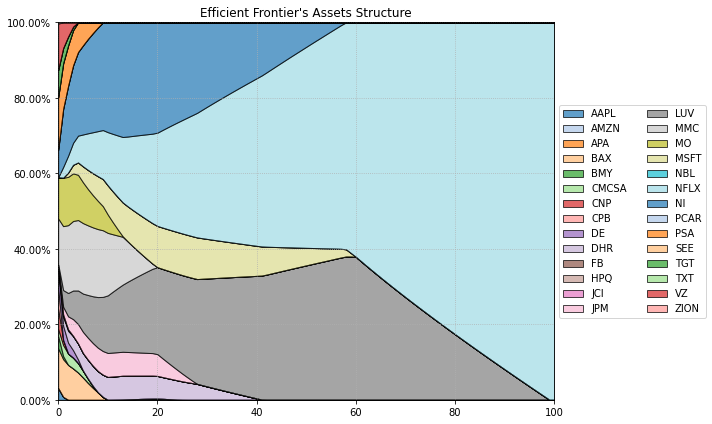

In [ ]:
# Plotting efficient frontier composition
ax = plf.plot_frontier_area(w_frontier=frontierRNN, cmap="tab20", height=6, width=10, ax=None)



MODELLO DI SELEZIONE DI PORTAFOGLIO CON RANDOM FOREST


In [ ]:
#Range di analisi
startRF = '2010-01-01'
endRF = '2019-01-01' 
# Tickers
assets = ['JCI', 'TGT', 'CMCSA', 'CPB', 'MO', 'NBL', 'APA', 'MMC', 'JPM',
          'ZION', 'PSA', 'BAX', 'BMY', 'LUV', 'PCAR', 'TXT', 'DHR',
          'DE', 'MSFT', 'HPQ', 'SEE', 'VZ', 'CNP', 'NI', 'AAPL','AMZN','NFLX','NVDA']
assets.sort()
#Scarico i dati
dataRF = yf.download(assets, start = startRF, end = endRF)
dataRF = dataRF.loc[:,('Adj Close', slice(None))]
dataRF.columns = assets
#Rendimenti
YRF = dataRF[assets].pct_change().dropna()
YRF.head()

[*********************100%***********************]  28 of 28 completed


,AAPL,AMZN,APA,BAX,BMY,CMCSA,CNP,CPB,DE,DHR,FB,HPQ,JCI,JPM,LUV,MMC,MO,MSFT,NBL,NFLX,NI,PCAR,PSA,SEE,TGT,TXT,VZ,ZION
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2012-05-21,5.8260%,1.9920%,2.7322%,1.2036%,-0.0306%,1.5205%,1.2232%,-1.9461%,2.8966%,2.1524%,-10.9861%,2.0037%,2.7533%,-2.9263%,2.3313%,0.8852%,0.5366%,1.6399%,3.5553%,2.5443%,1.5555%,2.4474%,2.0458%,1.0605%,0.6671%,5.1454%,-0.4575%,1.7515%
2012-05-22,-0.7679%,-1.2746%,-0.1088%,-0.3261%,0.3669%,0.8011%,0.6042%,-0.2443%,-0.5046%,-1.0820%,-8.9039%,-0.5025%,0.6513%,4.6139%,-0.8394%,0.7208%,-0.2826%,0.0336%,-0.3067%,-5.6175%,-0.1612%,0.3116%,-0.7509%,-0.8025%,1.5045%,-0.2127%,0.1209%,0.9688%
2012-05-23,2.4399%,0.9056%,0.3146%,-0.0577%,-0.9442%,-0.5183%,-0.5506%,-0.7652%,1.3613%,1.2282%,3.2258%,-3.2140%,0.8135%,0.7351%,1.0883%,0.4356%,-0.1260%,-2.1841%,0.2485%,6.2029%,-0.1211%,0.6989%,-0.0529%,1.1823%,0.1941%,1.1940%,-0.2657%,1.9190%
2012-05-24,-0.9184%,-0.9389%,-0.9651%,0.6162%,1.4453%,0.4863%,0.8053%,0.4318%,-0.3687%,0.1517%,3.2187%,3.2733%,0.7886%,-0.8464%,4.5454%,0.5886%,1.7024%,-0.1374%,-0.4250%,-2.2806%,0.8893%,-1.0283%,0.6056%,-1.1070%,0.8278%,0.2107%,0.2664%,-1.6736%
2012-05-25,-0.5360%,-1.0918%,0.3533%,-0.4976%,0.3031%,-0.2765%,0.7488%,0.0614%,-0.7004%,-0.1325%,-3.3909%,2.5723%,-0.6550%,-1.3836%,0.2288%,-0.5236%,-0.4650%,-0.0344%,-0.4860%,-0.0712%,0.3205%,-0.3896%,0.2859%,-0.4975%,0.6463%,-1.0933%,0.1450%,0.3723%


In [ ]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [ ]:
#Split Rendimenti
YnumpyRF = YRF.to_numpy()
n_steps_out = 10
n_steps_in = YRF.shape[0] - n_steps_out
X2, y2 = split_sequences(YnumpyRF, n_steps_in, n_steps_out)
n_features = len(assets)

In [ ]:
####Define model Random Forest
model1 = RandomForestRegressor(n_estimators=2000, verbose = 2, random_state=0)
X2 = X2.reshape((n_features,X2.shape[1]))
y2 = y2.reshape((n_features,n_steps_out))
model1.fit(X2, y2)
fin = YnumpyRF.shape[0]
x_input2 = YnumpyRF[n_steps_out:fin]
x_input2 = x_input2.reshape((n_features, n_steps_in))
yhatRF = model1.predict(x_input2)
yhatRF = yhatRF.T
YfinRF = vstack((YnumpyRF,yhatRF))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 2000
building tree 2 of 2000
building tree 3 of 2000
building tree 4 of 2000
building tree 5 of 2000
building tree 6 of 2000
building tree 7 of 2000
building tree 8 of 2000
building tree 9 of 2000
building tree 10 of 2000
building tree 11 of 2000
building tree 12 of 2000
building tree 13 of 2000
building tree 14 of 2000
building tree 15 of 2000
building tree 16 of 2000
building tree 17 of 2000
building tree 18 of 2000
building tree 19 of 2000
building tree 20 of 2000
building tree 21 of 2000
building tree 22 of 2000
building tree 23 of 2000
building tree 24 of 2000
building tree 25 of 2000
building tree 26 of 2000
building tree 27 of 2000
building tree 28 of 2000
building tree 29 of 2000
building tree 30 of 2000
building tree 31 of 2000
building tree 32 of 2000
building tree 33 of 2000
building tree 34 of 2000
building tree 35 of 2000
building tree 36 of 2000
building tree 37 of 2000
building tree 38 of 2000
building tree 39 of 2000
building tree 40 of 2000
building 

[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:   21.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:    0.1s finished


In [ ]:
#Modello di Markowitz con previsione RF
YfinRF = pd.DataFrame(YfinRF)
YfinRF.columns = assets
print(YfinRF.head())
portRF = pf.Portfolio(returns=YfinRF)


      AAPL     AMZN      APA      BAX  ...     TGT      TXT       VZ     ZION
0  5.8260%  1.9920%  2.7322%  1.2036%  ... 0.6671%  5.1454% -0.4575%  1.7515%
1 -0.7679% -1.2746% -0.1088% -0.3261%  ... 1.5045% -0.2127%  0.1209%  0.9688%
2  2.4399%  0.9056%  0.3146% -0.0577%  ... 0.1941%  1.1940% -0.2657%  1.9190%
3 -0.9184% -0.9389% -0.9651%  0.6162%  ... 0.8278%  0.2107%  0.2664% -1.6736%
4 -0.5360% -1.0918%  0.3533% -0.4976%  ... 0.6463% -1.0933%  0.1450%  0.3723%

[5 rows x 28 columns]


In [ ]:
#Ottimizzazione di portafoglio approccio storico
method_mu='hist' # Method to estimate expected returns based on historical data.
method_cov='hist' # Method to estimate covariance matrix based on historical data.
portRF.assets_stats(method_mu=method_mu, method_cov=method_cov, d=0.94)


In [ ]:
#Stima del portafoglio ottiamale
model='Classic' #Markowitz
rm = 'MV' #media-Varianza
obj = 'Sharpe' #ottimizzazione indice di Sharpe
hist = True #scenari storici come misura di rischio
rf = 0 # Risk free rate
l = 0 #Fattore avversità rispetto al rischio
#Pesi del portafoglio ottimale
wRF = portRF.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)
print(wRF.T)

           AAPL    AMZN     APA     BAX  ...     TGT     TXT      VZ    ZION
weights 0.0000% 9.3915% 0.0000% 0.5518%  ... 0.0000% 0.0000% 0.0000% 0.0000%

[1 rows x 28 columns]


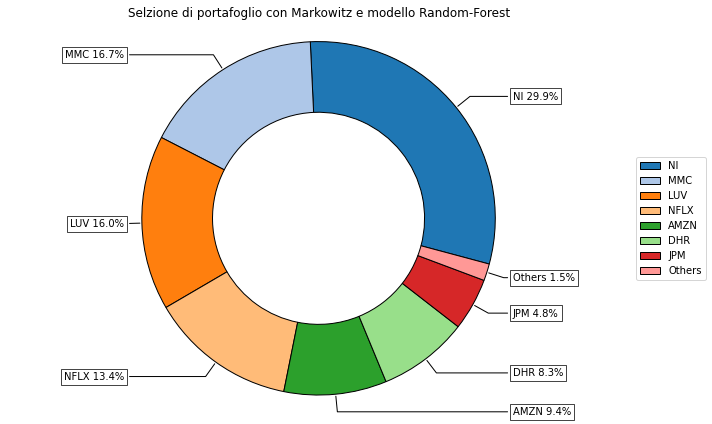

In [ ]:
# Plotting 
axRF = plf.plot_pie(w=wRF, title='Selzione di portafoglio con Markowitz e modello Random-Forest', others=0.05, nrow=28, cmap = "tab20",height=6, width=10, ax=None)


In [ ]:
#Frontiera Efficiente
points = 100 #Numero di punti simulati
frontierRF = portRF.efficient_frontier(model=model, rm=rm, points=points, rf=rf, hist=hist)
print(frontierRF.T.head())

     AAPL    AMZN     APA     BAX  ...     TGT     TXT       VZ    ZION
0 3.8310% 0.0000% 0.0000% 9.8620%  ... 7.4225% 0.0000% 13.6607% 0.0001%
1 2.7994% 0.9383% 0.0000% 9.1353%  ... 4.4794% 0.0000% 11.0297% 0.0000%
2 2.1244% 2.1942% 0.0000% 8.4765%  ... 3.0739% 0.0000%  9.6548% 0.0000%
3 1.5669% 3.2776% 0.0000% 7.7331%  ... 1.8235% 0.0000%  8.3295% 0.0000%
4 1.0906% 4.2015% 0.0000% 7.0839%  ... 0.7547% 0.0000%  7.1962% 0.0000%

[5 rows x 28 columns]


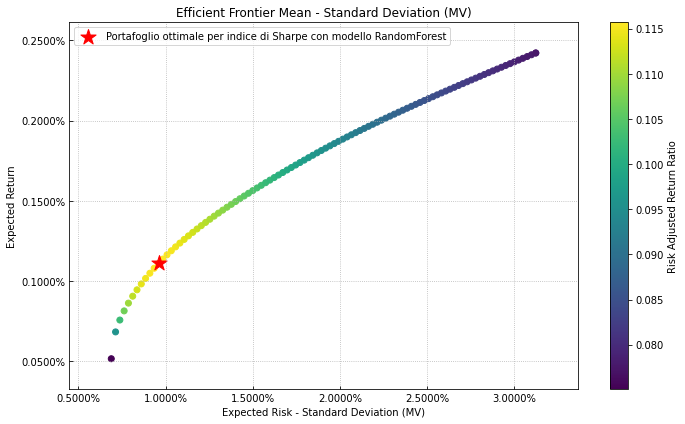

In [ ]:
# Plotting the efficient frontier
labelRF = 'Portafoglio ottimale per indice di Sharpe con modello RandomForest' # Title of point
muRF = portRF.mu # Expected returns
covRF = portRF.cov # Covariance matrix
returnsRF = portRF.returns # Returns of the assets
ax = plf.plot_frontier(w_frontier=frontierRF, mu=muRF, cov=covRF, returns=returnsRF, rm=rm,
                       rf=rf, alpha=0.01, cmap='viridis', w=wRF, label=labelRF,
                       marker='*', s=16, c='r', height=6, width=10, ax=None)


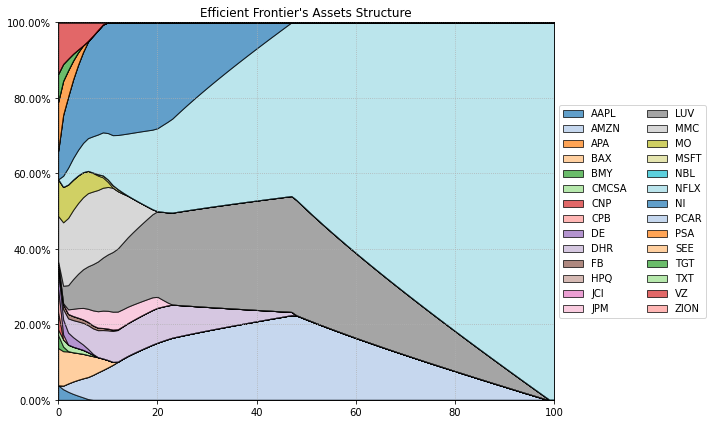

In [ ]:
# Plotting efficient frontier composition
ax = plf.plot_frontier_area(w_frontier=frontierRF, cmap="tab20", height=6, width=10, ax=None)



BACKTESTING


In [ ]:
#Backtesting con modello di Markowitz
startBT = '2019-01-01'
endBT = '2019-06-30' 
#Scarico i dati BT
dataBT = yf.download(assets, start = startBT, end = endBT)
dataBT = dataBT.loc[:,('Adj Close', slice(None))]
dataBT.columns = assets
#Rendimenti BT
Ybt = dataBT[assets].pct_change().dropna()
print(Ybt.head())

[*********************100%***********************]  28 of 28 completed
               AAPL     AMZN     APA  ...      TXT       VZ     ZION
Date                                  ...                           
2019-01-03 -9.9607% -2.5242% 0.2582%  ... -2.5385%  0.3570% -0.5532%
2019-01-04  4.2689%  5.0064% 4.1943%  ...  4.3633%  0.2490%  3.0714%
2019-01-07 -0.2226%  3.4353% 2.1540%  ... -0.9599%  0.6387%  0.3989%
2019-01-08  1.9063%  1.6612% 1.4864%  ...  2.4122%  2.9267%  0.9114%
2019-01-09  1.6982%  0.1714% 5.1090%  ... -0.5678% -1.2583%  0.8569%

[5 rows x 28 columns]


In [ ]:
#Rendimento PT con Markowitz
Ybt['Rendimenti del portafoglio con MARKOWITZ'] = Ybt[assets].dot(w)
Ybt['Rendimenti del portafoglio con Markowitz e modello RANDOM-FOREST'] = Ybt[assets].dot(wRF)
Ybt['Rendimenti del portafoglio con Markowitz e modello RNN'] = Ybt[assets].dot(wRNN)
portfolios = ['Rendimenti del portafoglio con MARKOWITZ', 'Rendimenti del portafoglio con Markowitz e modello RNN', 'Rendimenti del portafoglio con Markowitz e modello RANDOM-FOREST']


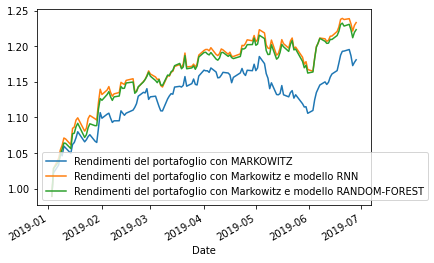

In [ ]:
#calcolo dei rendimenti cumulativi dei portafogli
Cumulative_returns_daily = (1+Ybt).cumprod()
Cumulative_returns_daily[portfolios].plot()